# Mandelbrot set

Mandelbrot set reference: https://en.wikipedia.org/wiki/Mandelbrot_set

In [41]:
%pip install jax
%pip install numba
%pip install matplotlib

/srv/conda/envs/notebook/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
# NumPy
import numpy as np

# JAX
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

# Numba
import numba as nb

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt

### Basic Python Implementation

In [43]:
def mandelbrot_python(height, width):
  y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
  c = x + y*1j
  fractal = np.full(c.shape, 20, dtype=np.int32)
  for h in range(height):
    for w in range(width):            # for each pixel (h, w)...
      z = c[h, w]
      for i in range(20):             # iterate at most 20 times
        z = z**2 + c[h, w]            # applying z → z² + c
        if abs(z) > 2:                # if it diverges (|z| > 2)
          fractal[h, w] = i           # color the plane with the iteration number
          break                       # we're done, no need to keep iterating
  return fractal

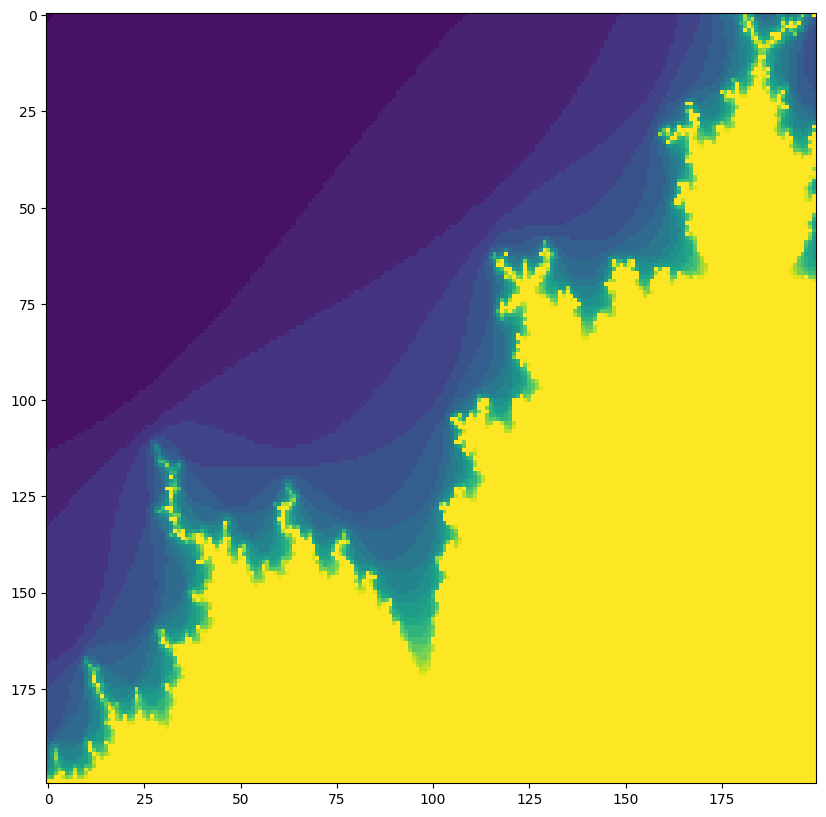

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(mandelbrot_python(200, 200))

In [45]:
%%timeit -n 10 -r 3

mandelbrot_python(200, 200)

173 ms ± 2.51 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [46]:
%%timeit -n 1 -r 1

mandelbrot_python(2000, 2000)

17.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Oh no, this calculation scales with $height \times width$ ($\mathcal{O}(N^2)$)!

This algorithm can't be implemented with less time complexity, so we have to make use of compiled kernels...

Let's switch from Python to NumPy to achieve this:

In [47]:
def mandelbrot_numpy(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = np.full(c.shape, 20, dtype=np.int32)
    z = c
    for i in range(20):
        z = z**2 + c                                 # applying z → z² + c
        diverged = z.real**2 + z.imag**2 > 4         # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == 20)   # some are already done
        fractal[diverging_now] = i                   # just set the new ones
        z[diverged] = 2                              # clamp diverged at 2
    return fractal

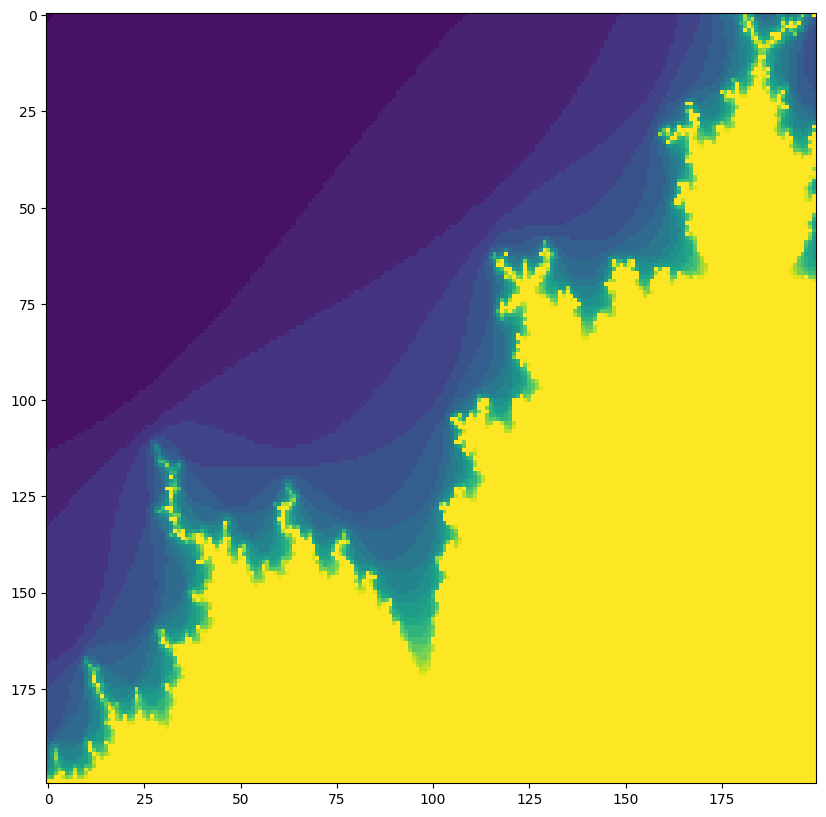

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(mandelbrot_numpy(200, 200))

In [49]:
%%timeit -n 10 -r 3

mandelbrot_numpy(200, 200)

3.22 ms ± 59.3 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [50]:
%%timeit -n 1 -r 1

mandelbrot_numpy(2000, 2000)

842 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Much better, but can it be even _faster_ with the help of JIT-compilation?

### Your task

Find a faster solution to calculate this patch of the mandelbrot set in:

1. JAX
2. Numba


#### Bonus task

What's the highest resolution you can achieve that takes less than 1s?

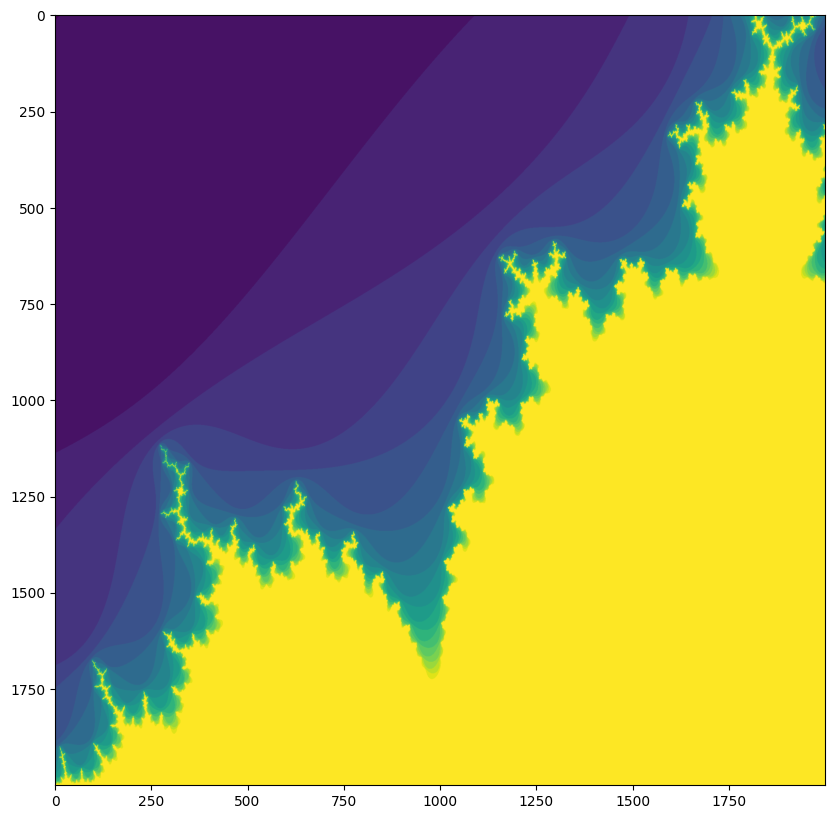

In [54]:
@jax.jit
def mandelbrot_jnp_kernel(x, y):
    c = x + y*1j
    fractal = jnp.full(c.shape, 20, dtype=jnp.int32)
    z = c
    for i in range(20):
        z = z**2 + c                                 # applying z → z² + c
        diverged = z.real**2 + z.imag**2 > 4         # |z| > 2 is "divergence"
        diverging_now = diverged & (fractal == 20)   # some are already done
        fractal = jnp.where(diverging_now, i, fractal)
        #fractal[diverging_now] = i                   # just set the new ones
        #z[diverged] = 2                              # clamp diverged at 2
    return fractal

def mandelbrot_jnp(height, width):
    y, x = np.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    return mandelbrot_jnp_kernel(x, y)

#mandelbrot_jnp(2000,2000)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(mandelbrot_jnp(2000, 2000))

In [55]:
%%timeit -n 1 -r 1

mandelbrot_jnp(2000,2000)

265 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
